# Goals

### 1. Learn to implement Inception D Block using monk
    - Monk's Keras
    - Monk's Pytorch
    - Monk's Mxnet
    
### 2. Use network Monk's debugger to create complex blocks 


### 3. Understand how syntactically different it is to implement the same using
    - Traditional Keras
    - Traditional Pytorch
    - Traditional Mxnet

# Inception D Block
 
 - Note: The block structure can have variations too, this is just an example

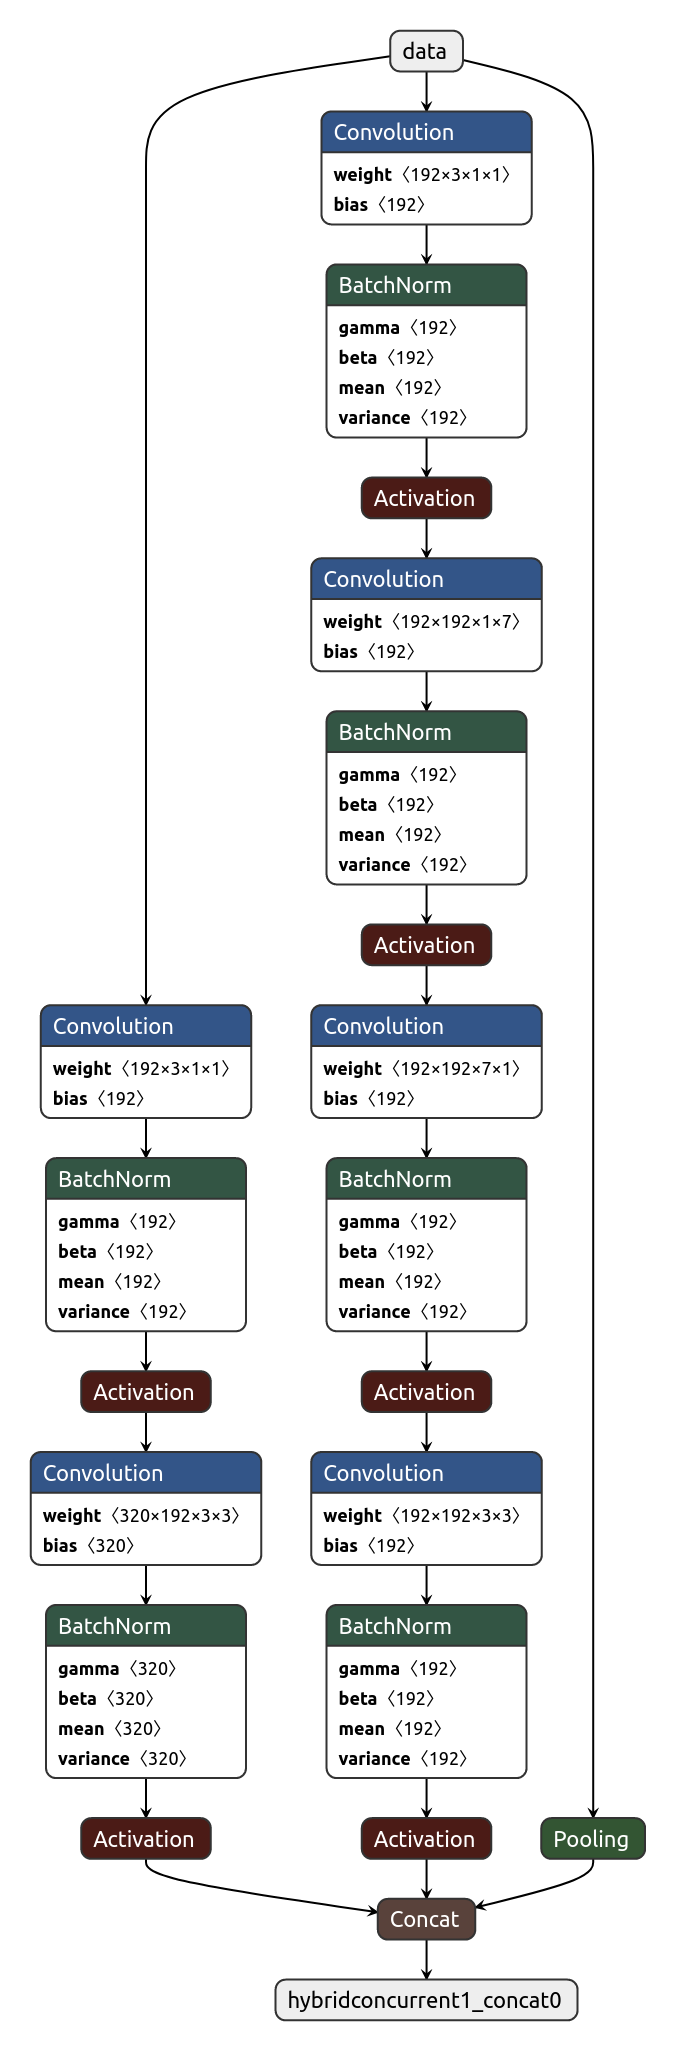

In [6]:
from IPython.display import Image
Image(filename='imgs/inception_d.png')

# Table of contents

[1. Install Monk](#1)


[2. Block basic Information](#2)

  - [2.1) Visual structure](#2-1)
  
  - [2.2) Layers in Branches](#2-2)


[3) Creating Block using monk visual debugger](#3)

  - [3.0) Create the base sub-block](#3-0)
  
  - [3.1) Create the first branch](#3-1)

  - [3.2) Create the second branch](#3-2)
  
  - [3.3) Create the third branch](#3-3)
  
  - [3.4) Merge the branches](#3-5)
  
  - [3.5) Debug the merged network](#3-6)
  
  - [3.6) Compile the network](#3-7)
  
  - [3.7) Visualize the network](#3-8)
  
  - [3.8) Run data through the network](#3-9)
  
  
[4) Creating Block Using MONK one line API call](#4)

  - [Mxnet Backend](#4-1)
  
  - [Pytorch Backend](#4-2)
  
  - [Keras Backend](#4-3)
  
  
  
[5) Appendix](#5)

  - [Study Material](#5-1)
  
  - [Creating block using traditional Mxnet](#5-2)
  
  - [Creating block using traditional Pytorch](#5-3)
  
  - [Creating block using traditional Keras](#5-4)
    

<a id='1'></a>
# Install Monk
  
 - git clone https://github.com/Tessellate-Imaging/monk_v1.git
 
 - cd monk_v1/installation && pip install -r requirements_cu9.txt
     - (Select the requirements file as per OS and CUDA version)

In [ ]:
!git clone https://github.com/Tessellate-Imaging/monk_v1.git

# Imports

In [1]:
# Common
import numpy as np
import math
import netron
from collections import OrderedDict
from functools import partial

In [2]:
# Monk
import os
import sys
sys.path.append("monk_v1/monk/");

<a id='2'></a>
# Block Information

<a id='2_1'></a>
## Visual structure

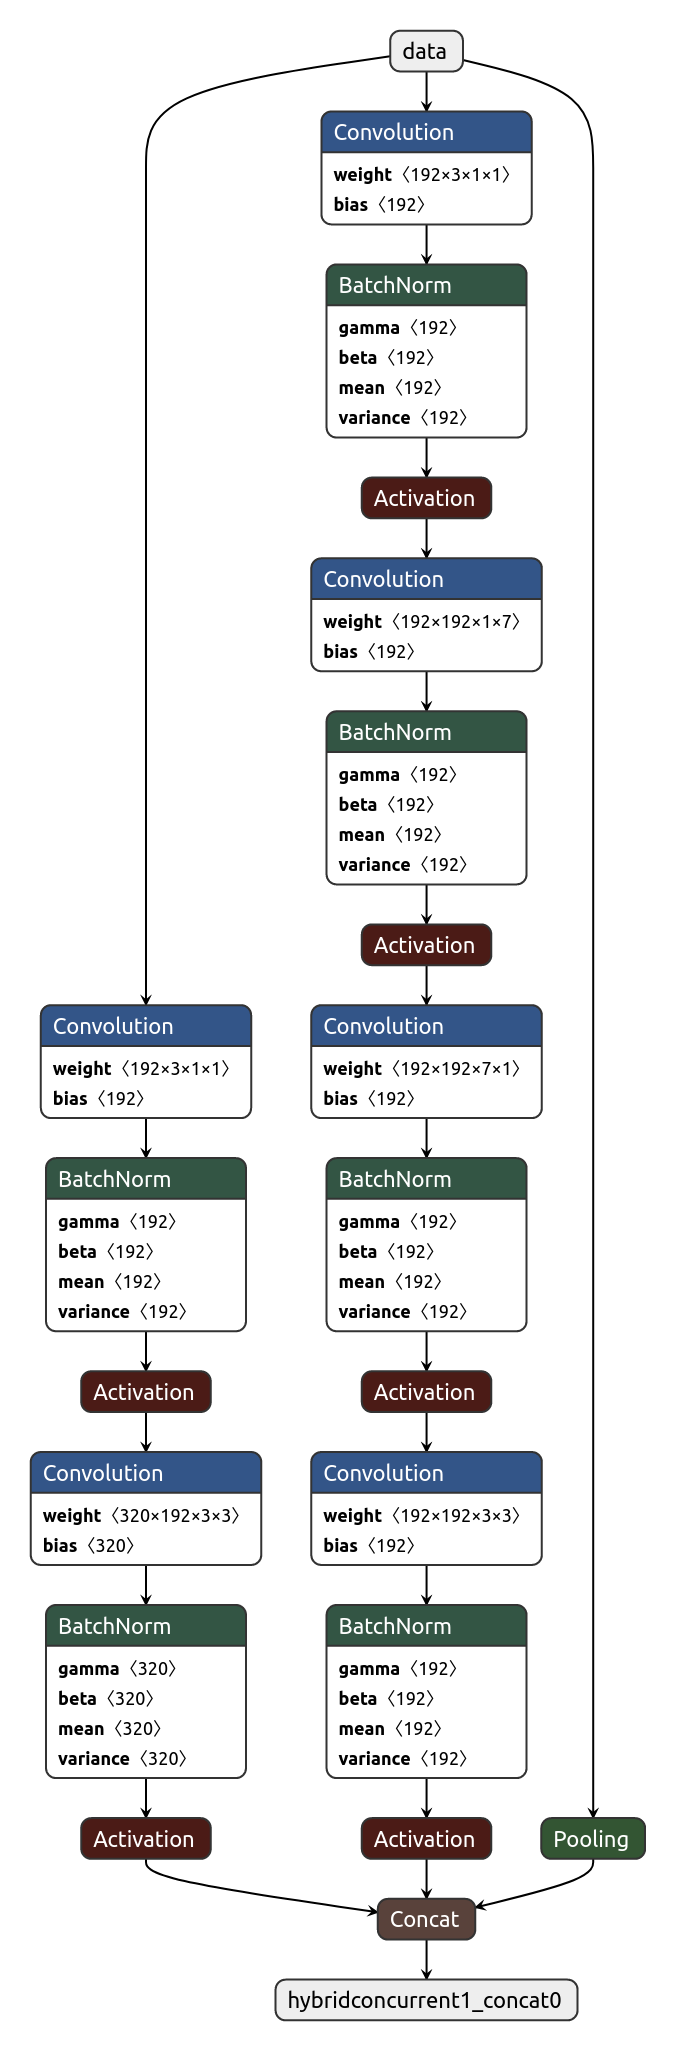

In [7]:
from IPython.display import Image
Image(filename='imgs/inception_d.png')

<a id='2_2'></a>
## Layers in Branches

  - Number of branches: 4
  
  
  - Branch 1
    - conv1x1 -> batchnorm -> relu -> conv3x3 -> batchnorm -> relu
  
  
  - Branch 2
    - conv_1x1 -> batchnorm -> relu -> conv_1x7 -> batchnorm -> relu -> conv_7x1 -> batchnorm -> relu -> conv3x3 -> batchnorm -> relu
    
    
  - Branch 3
    - pooling
    
    
    
  - Branches merged using
    - Concatenation
    
    
   
    
(See Appendix to read blogs on inception networks)

<a id='3'></a>
# Creating Block using monk debugger

In [8]:
# Imports and setup a project
# To use pytorch backend - replace gluon_prototype with pytorch_prototype
# To use keras backend - replace gluon_prototype with keras_prototype

from gluon_prototype import prototype

# Create a sample project
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/



<a id='3-0'></a>
## Create the Base block

In [9]:
# Create Base Convolution->Batchnorn->RELU block
def conv_bn_relu_block(output_channels=64, kernel_size=1, stride=1, padding=None):
    network = [];
    if(padding):
        network.append(gtf.convolution(output_channels=output_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride,
                                       padding=padding));
    else:
        network.append(gtf.convolution(output_channels=output_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    
    return network;


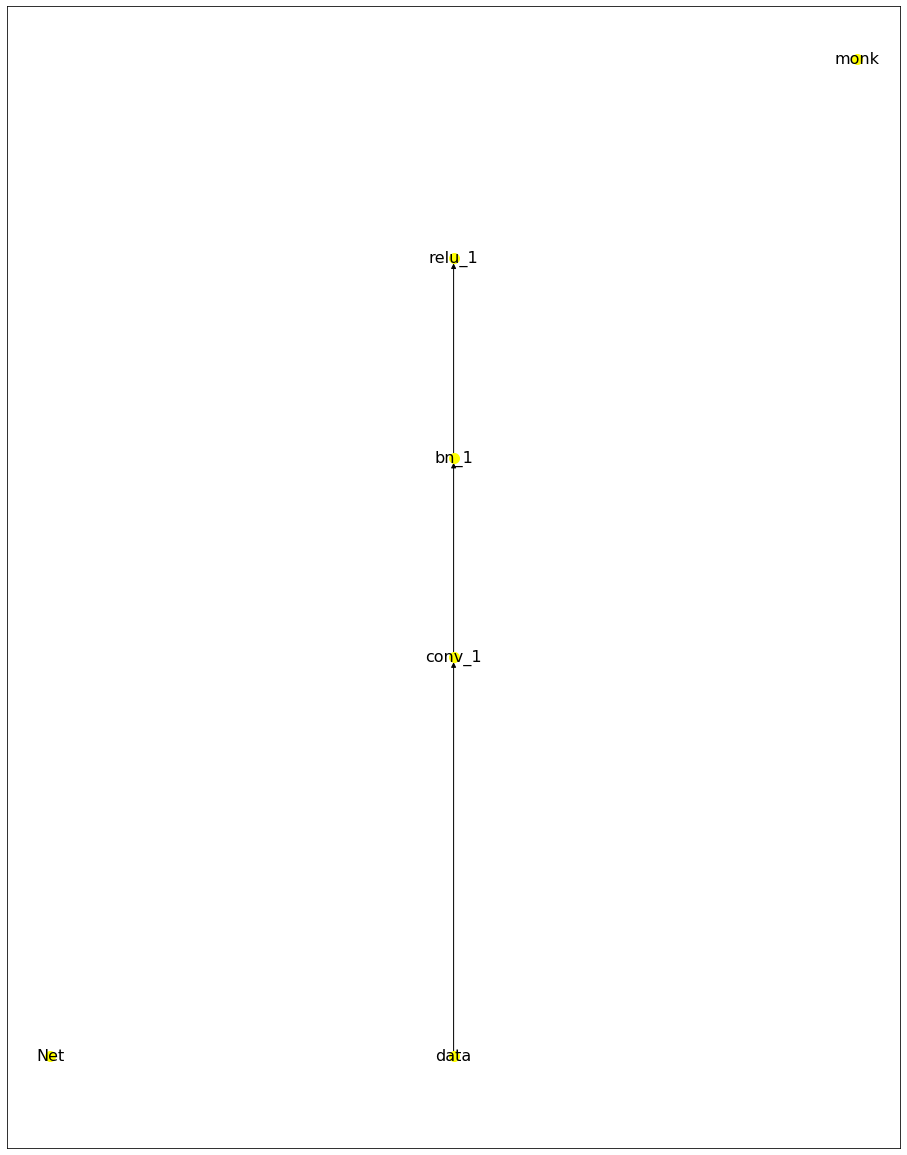

In [10]:
# Debug the block
branch_1 = conv_bn_relu_block();
network = [];
network.append(branch_1);
gtf.debug_custom_model_design(network);

<a id='3-1'></a>
## Create the first branch

In [11]:
def first_branch():
    network = [];
    network.append(conv_bn_relu_block(output_channels=192, kernel_size=1))
    network.append(conv_bn_relu_block(output_channels=320, kernel_size=3, stride=2))
    return network;

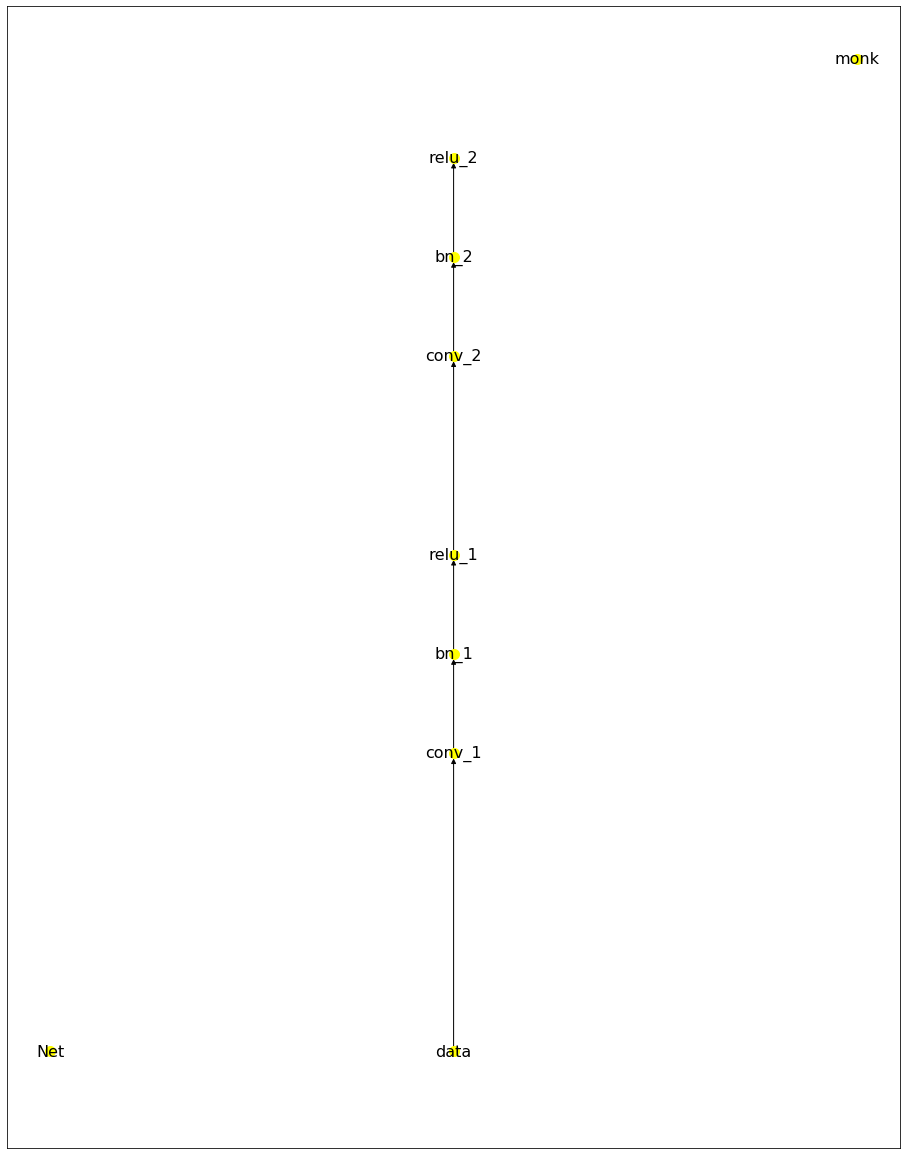

In [12]:
# Debug the branch
branch_1 = first_branch();
network = [];
network.append(branch_1);
gtf.debug_custom_model_design(network);

<a id='3-2'></a>
## Create the second branch

In [13]:
def second_branch():
    network = [];
    network.append(conv_bn_relu_block(output_channels=192, kernel_size=1));
    network.append(conv_bn_relu_block(output_channels=192, kernel_size=(1, 7), padding=(0, 3)));
    network.append(conv_bn_relu_block(output_channels=192, kernel_size=(7, 1), padding=(3, 0)));
    network.append(conv_bn_relu_block(output_channels=192, kernel_size=3, stride=2));
    return network;

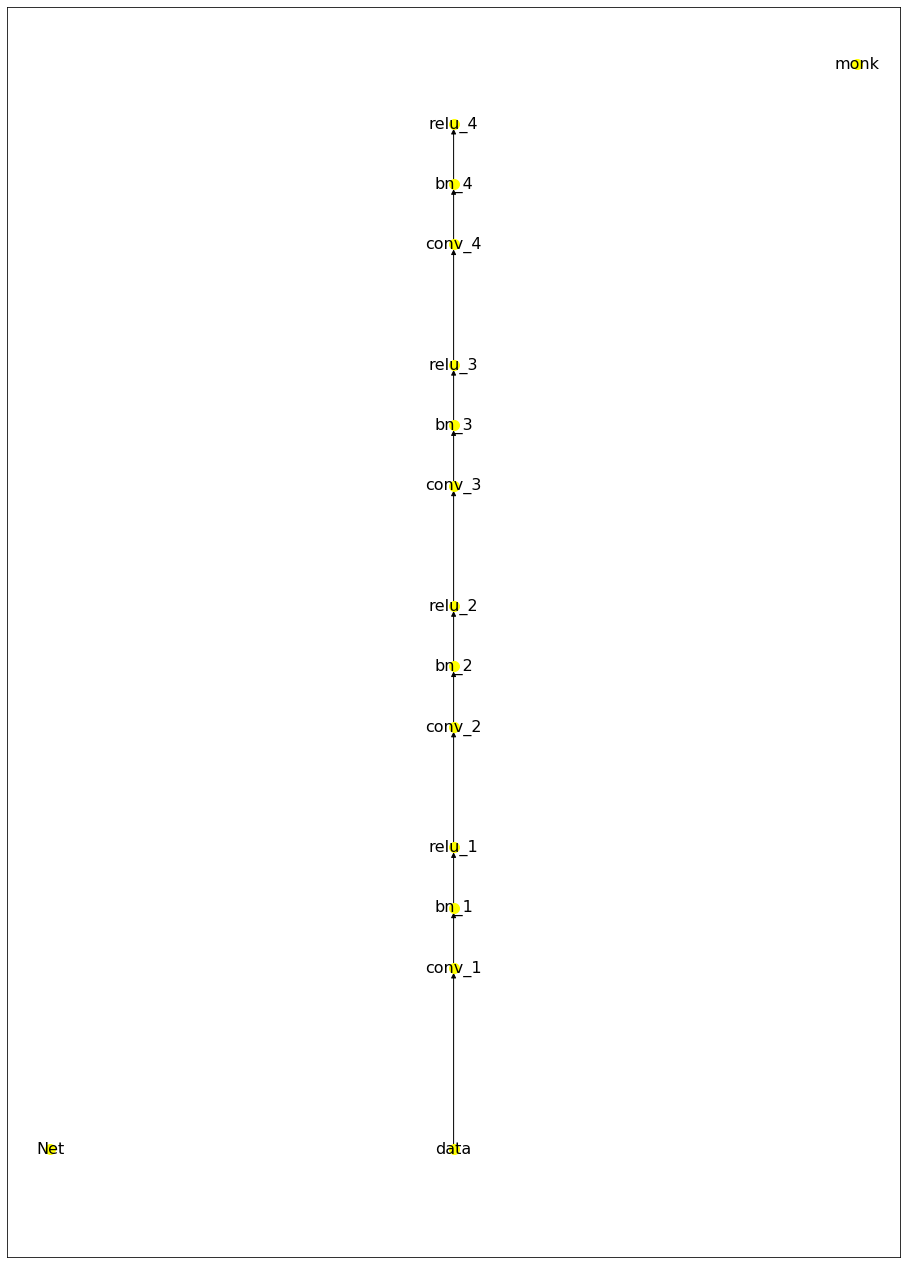

In [15]:
# Debug the branch
branch_2 = second_branch()
network = [];
network.append(branch_2);
gtf.debug_custom_model_design(network);

<a id='3-3'></a>
## Create the Third branch

In [16]:
def third_branch(pool_type="avg"):
    network = [];
    if(pool_type=="avg"):
        network.append(gtf.average_pooling(kernel_size=3, stride=2));
    else:
        network.append(gtf.max_pooling(kernel_size=3, stride=2));
    return network;

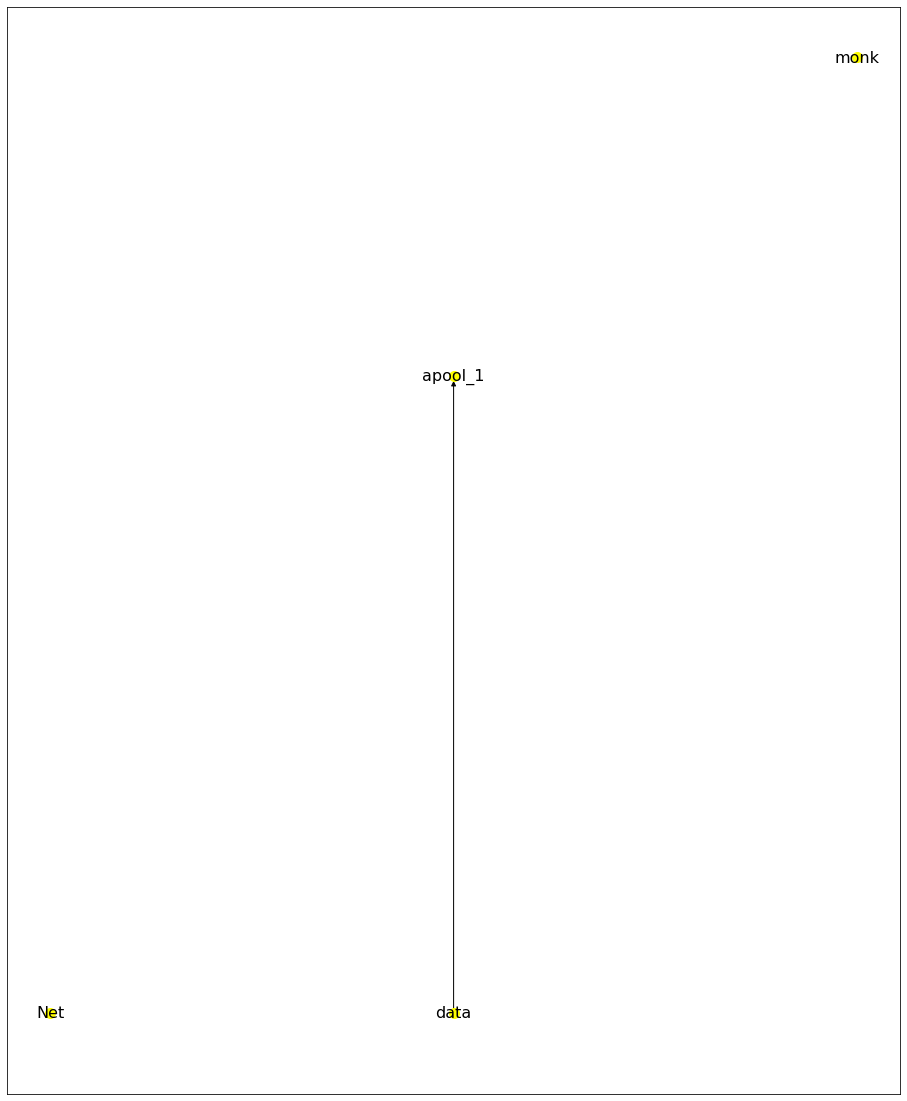

In [18]:
# Debug the branch
branch_3 = third_branch(pool_type="avg")
network = [];
network.append(branch_3);
gtf.debug_custom_model_design(network);

<a id='3-5'></a>
## Merge the branches

In [19]:

def final_block(pool_type="avg"):
    network = [];
    
    #Create subnetwork and add branches
    subnetwork = [];
    branch_1 = first_branch()
    branch_2 = second_branch()
    branch_3 = third_branch(pool_type=pool_type)
    subnetwork.append(branch_1);
    subnetwork.append(branch_2);
    subnetwork.append(branch_3);
    
    # Add merging element
    subnetwork.append(gtf.concatenate());
    
    # Add the subnetwork
    network.append(subnetwork);
    return network;

<a id='3-6'></a>
## Debug the merged network

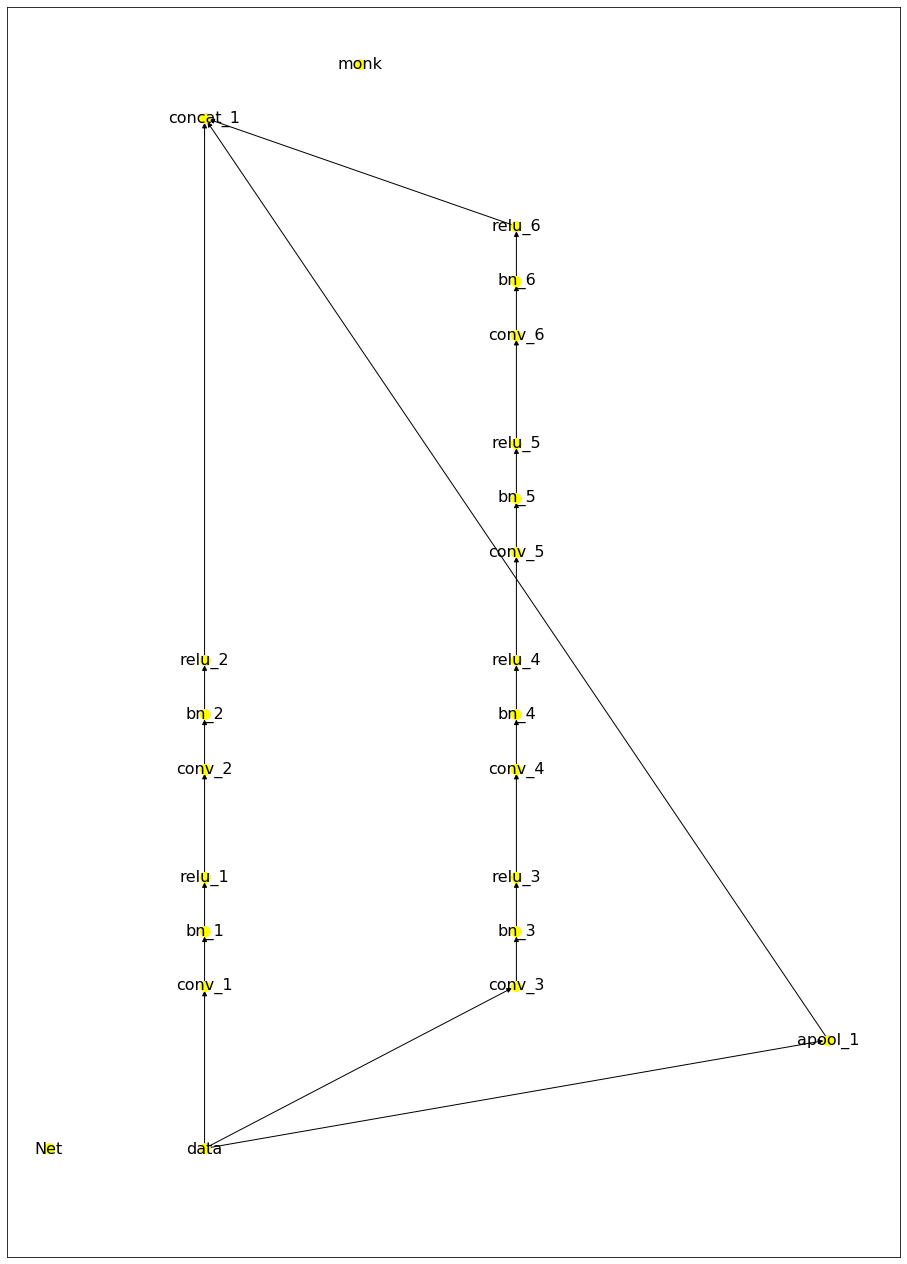

In [20]:
final = final_block(pool_type="avg")
network = [];
network.append(final);
gtf.debug_custom_model_design(network);

<a id='3-7'></a>
## Compile the network

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  12
        Num of actual trainable layers:       12



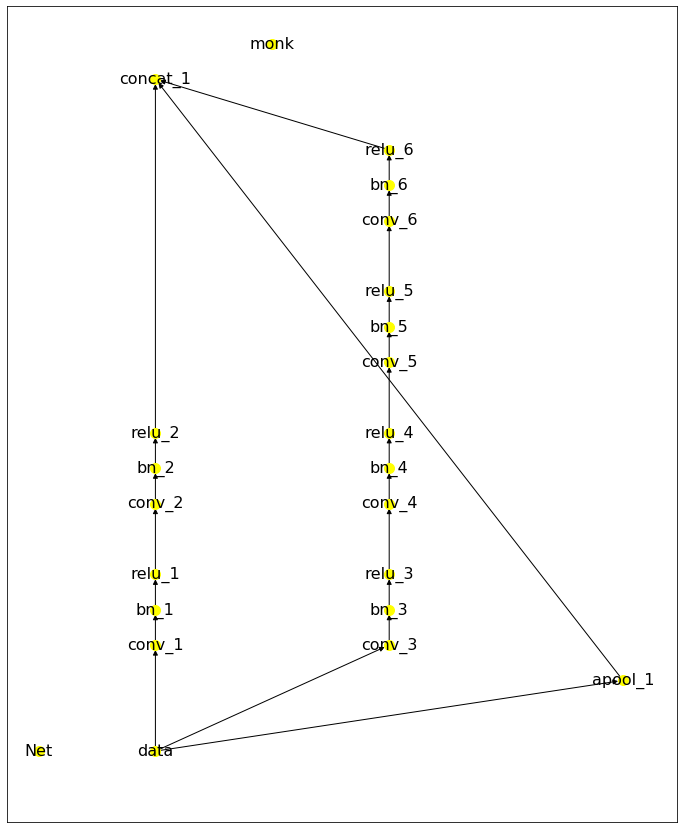

In [21]:
gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='3-8'></a>
## Run data through the network

In [22]:
import mxnet as mx
x = np.zeros((1, 3, 224, 224));
x = mx.nd.array(x);
y = gtf.system_dict["local"]["model"].forward(x);
print(x.shape, y.shape)

(1, 3, 224, 224) (1, 515, 111, 111)


<a id='3-9'></a>
## Visualize network using netron

In [23]:
gtf.Visualize_With_Netron(data_shape=(3, 224, 224))

Using Netron To Visualize
Not compatible on kaggle
Compatible only for Jupyter Notebooks

Stopping http://localhost:8080
Serving 'model-symbol.json' at http://localhost:8080


<a id='4'></a>
# Creating Using MONK LOW code API

<a id='4-1'></a>
## Mxnet backend

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  12
        Num of actual trainable layers:       12



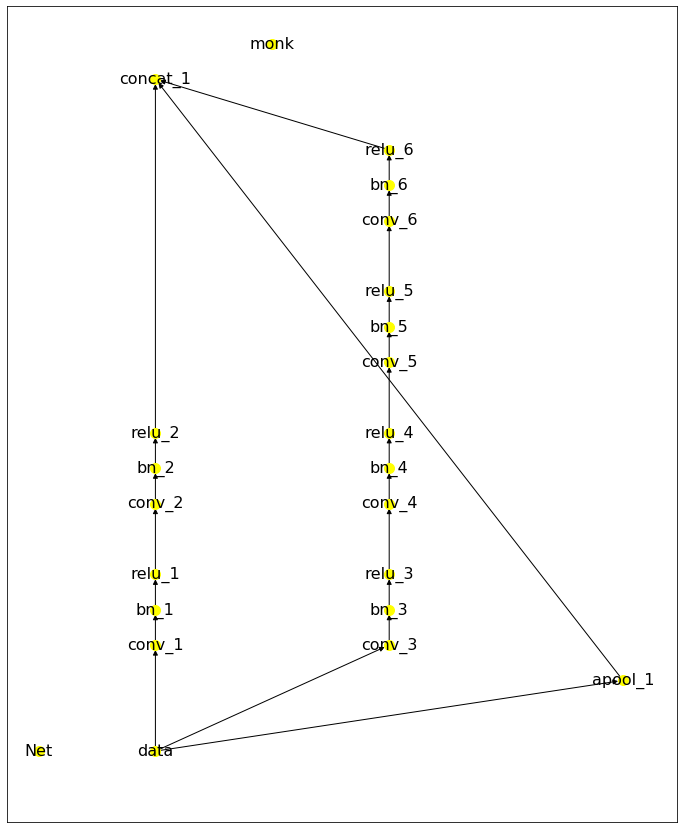

In [24]:
from gluon_prototype import prototype
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.inception_d_block(pool_type="avg"));

gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);


<a id='4-2'></a>
## Pytorch backend

  - Only the import changes

Pytorch Version: 1.2.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  12
        Num trainable layers: 12



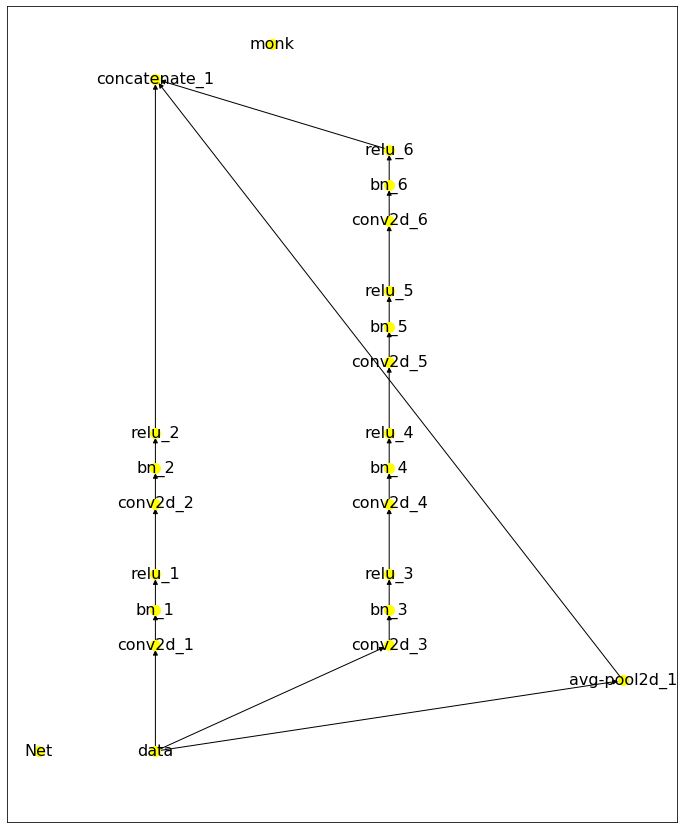

In [25]:
#Change gluon_prototype to pytorch_prototype
from pytorch_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.inception_d_block(pool_type="avg"));


gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='4-3'></a>
## Keras backend

  - Only the import changes

Keras Version: 2.2.5
Tensorflow Version: 1.12.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  21
        Num trainable layers: 20



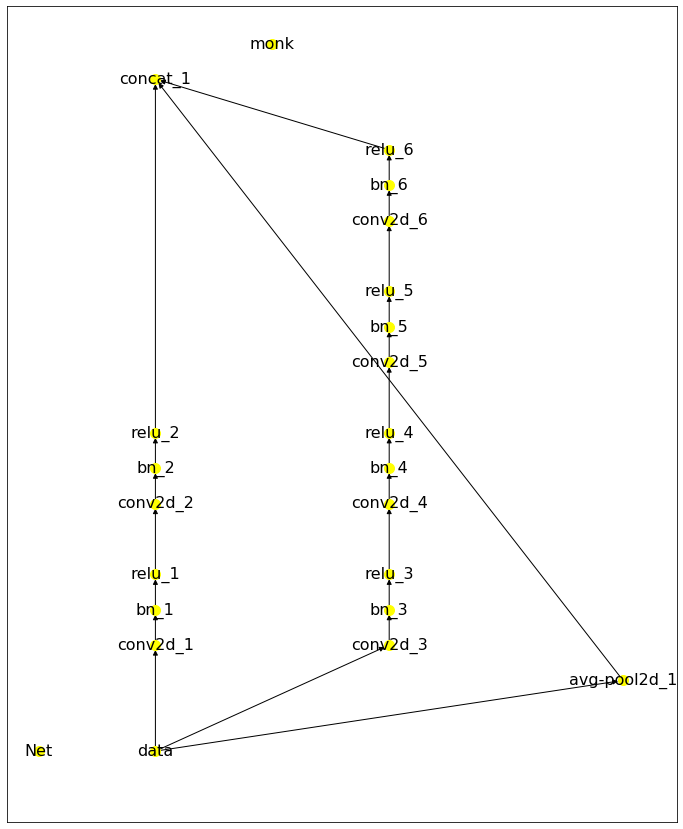

In [26]:
#Change gluon_prototype to keras_prototype
from keras_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.inception_d_block(pool_type="avg"));


gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='5'></a>
# Appendix

<a id='5-1'></a>
## Study links
  - https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c
  - https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
  - https://software.intel.com/en-us/articles/inception-v3-deep-convolutional-architecture-for-classifying-acute-myeloidlymphoblastic
  - https://codelabs.developers.google.com/codelabs/cpb102-txf-learning/index.html#0
  - https://cloud.google.com/tpu/docs/inception-v3-advanced

<a id='5-2'></a>
## Creating block using traditional Mxnet

 - Code credits - https://mxnet.incubator.apache.org/

In [27]:
# Traditional-Mxnet-gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.nn import HybridBlock, BatchNorm
from mxnet.gluon.contrib.nn import HybridConcurrent, Identity
from mxnet import gluon, init, nd

In [28]:
def _make_basic_conv(norm_layer=BatchNorm, norm_kwargs=None, **kwargs):
    out = nn.HybridSequential(prefix='')
    out.add(nn.Conv2D(use_bias=False, **kwargs))
    out.add(norm_layer(epsilon=0.001, **({} if norm_kwargs is None else norm_kwargs)))
    out.add(nn.Activation('relu'))
    return out

def _make_branch(use_pool, norm_layer, norm_kwargs, *conv_settings):
    out = nn.HybridSequential(prefix='')
    if use_pool == 'avg':
        out.add(nn.AvgPool2D(pool_size=3, strides=1, padding=1))
    elif use_pool == 'max':
        out.add(nn.MaxPool2D(pool_size=3, strides=2))
    setting_names = ['channels', 'kernel_size', 'strides', 'padding']
    for setting in conv_settings:
        kwargs = {}
        for i, value in enumerate(setting):
            if value is not None:
                kwargs[setting_names[i]] = value
        out.add(_make_basic_conv(norm_layer, norm_kwargs, **kwargs))
    return out


def make_D(prefix=None, norm_layer=BatchNorm, norm_kwargs=None):
    out = HybridConcurrent(axis=1, prefix=prefix)
    with out.name_scope():
        out.add(_make_branch(None, norm_layer, norm_kwargs,
                             (192, 1, None, None),
                             (320, 3, 2, None)))
        out.add(_make_branch(None, norm_layer, norm_kwargs,
                             (192, 1, None, None),
                             (192, (1, 7), None, (0, 3)),
                             (192, (7, 1), None, (3, 0)),
                             (192, 3, 2, None)))
        out.add(_make_branch('max', norm_layer, norm_kwargs))
    return out

In [30]:
# Invoke the block
block = make_D()

# Initialize network and load block on machine
ctx = [mx.cpu()];
block.initialize(init.Xavier(), ctx = ctx);
block.collect_params().reset_ctx(ctx)
block.hybridize()

# Run data through network
x = np.zeros((1, 3, 224, 224));
x = mx.nd.array(x);
y = block.forward(x);
print(x.shape, y.shape)


# Export Model to Load on Netron
block.export("final", epoch=0);

netron.start("final-symbol.json", port=8082)

(1, 3, 224, 224) (1, 515, 111, 111)
Serving 'final-symbol.json' at http://localhost:8082


<a id='5-3'></a>
## Creating block using traditional Pytorch

 - Code credits - https://pytorch.org/

In [31]:
# Traiditional-Pytorch
import torch
from torch import nn
from torch.jit.annotations import List
import torch.nn.functional as F

In [32]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionD(nn.Module):

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)

In [33]:
# Invoke the block
block = InceptionD(3);

# Initialize network and load block on machine
layers = []
layers.append(block);
net = nn.Sequential(*layers);

# Run data through network
x = torch.randn(1, 3, 224, 224)
y = net(x)
print(x.shape, y.shape);

# Export Model to Load on Netron
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})
netron.start('model.onnx', port=9998);

torch.Size([1, 3, 224, 224]) torch.Size([1, 515, 111, 111])
Serving 'model.onnx' at http://localhost:9998


<a id='5-4'></a>
## Creating block using traditional Keras

 - Code credits: https://keras.io/

In [38]:
# Traditional-Keras
import keras
import keras.layers as kla
import keras.models as kmo
import tensorflow as tf
from keras.models import Model
backend = 'channels_last'
from keras import layers

In [39]:
def inception_d_block(input_tensor, stage, block):
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    branch_1 = layers.Conv2D(192, (1, 1),
                      kernel_initializer='he_normal')(input_tensor)
    branch_1 = layers.BatchNormalization(axis=bn_axis)(branch_1)
    branch_1 = layers.Activation('relu')(branch_1)
    branch_1 = layers.Conv2D(320, (3, 3),
                              kernel_initializer='he_normal', 
                              strides=2,
                                padding="same")(branch_1)
    branch_1 = layers.BatchNormalization(axis=bn_axis)(branch_1)
    branch_1 = layers.Activation('relu')(branch_1)
    
    
    branch_2 = layers.Conv2D(192, (1, 1),
                      kernel_initializer='he_normal')(input_tensor)
    branch_2 = layers.BatchNormalization(axis=bn_axis)(branch_2)
    branch_2 = layers.Activation('relu')(branch_2)
    branch_2 = layers.Conv2D(192, (1, 7),
                      kernel_initializer='he_normal', padding="same")(input_tensor)
    branch_2 = layers.BatchNormalization(axis=bn_axis)(branch_2)
    branch_2 = layers.Activation('relu')(branch_2)
    branch_2 = layers.Conv2D(192, (7, 1),
                      kernel_initializer='he_normal', padding="same")(input_tensor)
    branch_2 = layers.BatchNormalization(axis=bn_axis)(branch_2)
    branch_2 = layers.Activation('relu')(branch_2)
    branch_2 = layers.Conv2D(192, (3, 3),
                              kernel_initializer='he_normal', 
                              strides=2,
                                padding="same")(branch_2)
    branch_2 = layers.BatchNormalization(axis=bn_axis)(branch_2)
    branch_2 = layers.Activation('relu')(branch_2)
       
    
    branch_3 = layers.AveragePooling2D(pool_size=(3, 3), 
                                       strides=(2, 2), 
                                       padding='same', 
                                       data_format=None)(input_tensor)
    
    
    x = layers.Concatenate()([branch_1, branch_2, branch_3])
    
    return x

def create_model(input_shape, stage, block):
    img_input = layers.Input(shape=input_shape);
    x = inception_d_block(img_input, stage, block)    
    return Model(img_input, x);

In [40]:
# Invoke the block
input_shape=(224, 224, 3);
model = create_model(input_shape, 0, "0");

# Run data through network
x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
y = model(x)
print(x.shape, y.shape)

# Export Model to Load on Netron
model.save("final.h5");
netron.start("final.h5", port=8082)

(1, 224, 224, 3) (1, 112, 112, 515)

Stopping http://localhost:8082
Serving 'final.h5' at http://localhost:8082
